# Histogram Tracking

Kevin J. Walchko, created 5 Dec 2016


----------

Finding and tracking a specific object through a series of images is not hard under good conditions. Tyically it can be divided up into several steps:

1. seach an image and find the object you want. You will need some sort of a priori model to find the image that was developed off line.
2. assuming the object doesn't move in a non-linear motion or out of frame between 2 consequtive images. Start at the last known location of the object in the previous image and search the local area for the object again.
3. Continue tracking through the sequence of images until you are done.



In [3]:
%matplotlib inline

In [4]:
from __future__ import print_function
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
import cv2
import time

## Where's Mario?

Let's take a look at trying to find Mario in some images. First we need to move switch between RGB and HSV color space.
* The **hue** (H) of a color refers to which pure color it resembles. All tints, tones and shades of red have the same hue. Hues are described by a number that specifies the position of the corresponding pure color on the color wheel, as a fraction between 0 and 1. Value 0 refers to red; 1/6 is yellow; 1/3 is green; and so forth around the color wheel.
* The **saturation** (S) of a color describes how white the color is. A pure red is fully saturated, with a saturation of 1; tints of red have saturations less than 1; and white has a saturation of 0.
* The **value** (V) of a color, also called its lightness, describes how dark the color is. A value of 0 is black, with increasing lightness moving away from black

A good resource for understanding RGB and HSV is [colorizer.org](http://colorizer.org/) where you can play with some sliders and see how it changes the color in different color spaces.

For HSV, Hue range is [0,179], Saturation range is [0,255] and Value range is [0,255]. Different softwares use different scales. So if you are comparing OpenCV values with them, you need to normalize these ranges.   [ref](http://docs.opencv.org/trunk/df/d9d/tutorial_py_colorspaces.html)

## Why?

The big reason is that it separates color information (chroma) from intensity or lighting (luma). Because value is separated, you can construct a histogram or thresholding rules using only saturation and hue. This in theory will work regardless of lighting changes in the value channel. In practice it is just a nice improvement. Even by singling out only the hue you still have a very meaningful representation of the base color that will likely work much better than RGB. The end result is a more robust color thresholding over simpler parameters.

Hue is a continuous representation of color so that 0 and 360 are the same hue which gives you more flexibility with the buckets you use in a histogram. Geometrically you can picture the HSV color space as a cone or cylinder with H being the degree, saturation being the radius, and value being the height. 

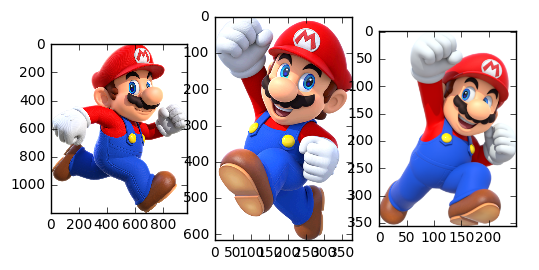

In [218]:
images = ['hist_pics/mario-1.png', 'hist_pics/mario-2.png', 'hist_pics/mario-3.png', 'hist_pics/mario-4.png', 'hist_pics/mario-5.png', 'hist_pics/mario-6.png']
rgb = []
for image in images:
    i = cv2.imread(image, cv2.IMREAD_COLOR)
    i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)  # pretty images
    rgb.append(i)

plt.subplot(1,3,1)
plt.imshow(rgb[0]);
plt.subplot(1,3,2)
plt.imshow(rgb[1]);
plt.subplot(1,3,3)
plt.imshow(rgb[2]);

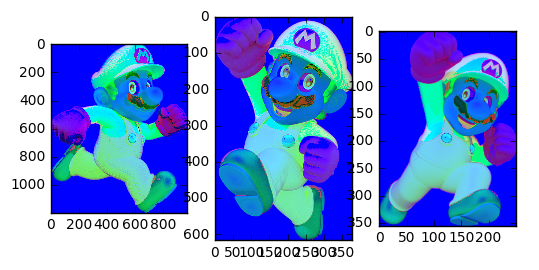

In [219]:
hsv = []
for i, image in enumerate(rgb):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv.append(img)


plt.subplot(1,3,1)
plt.imshow(hsv[0]);
plt.subplot(1,3,2)
plt.imshow(hsv[1]);
plt.subplot(1,3,3)
plt.imshow(hsv[2]);

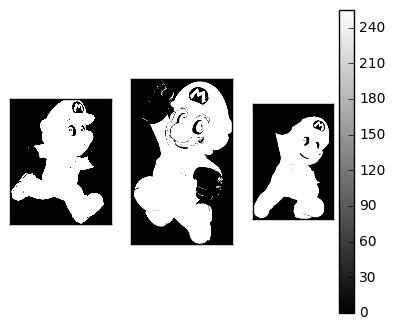

In [254]:
# let's define a mask to block out things we don't want
# since our back ground is white hsv = [x,0,255] where is x is don't care
# white is s=0, v=255
masks = []
for image in hsv:
    h,s,v = cv2.split(image)
#     ret,vv = cv2.threshold(v,250,255,cv2.THRESH_BINARY)
#     masks.append(vv)
    ret,ss = cv2.threshold(s,50,255,cv2.THRESH_BINARY)
    masks.append(ss)
#     ss = cv2.merge((ss,ss,ss))

plt.subplot(1,4,1)
plt.imshow(masks[0], cmap = 'gray', interpolation = 'bicubic');
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.subplot(1,4,2)
plt.imshow(masks[1], cmap = 'gray', interpolation = 'bicubic');
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.subplot(1,4,3)
plt.imshow(masks[2], cmap = 'gray', interpolation = 'bicubic');
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.colorbar();
# plt.subplot(1,4,4)
# plt.imshow(masks[0]);

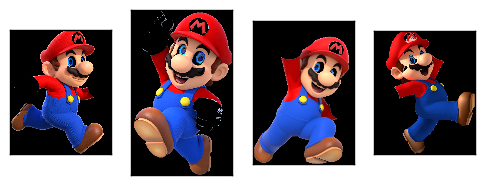

In [271]:
# let's take a look at our masks and see what shows through
tmp = []
for i in range(len(masks)):
    ret = cv2.bitwise_and(rgb[i], cv2.merge((masks[i],masks[i],masks[i])))
    tmp.append(ret)
plt.subplot(1,4,1)
plt.imshow(tmp[0]);
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.subplot(1,4,2)
plt.imshow(tmp[1]);
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.subplot(1,4,3)
plt.imshow(tmp[2]);
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.subplot(1,4,4)
plt.imshow(tmp[3]);
plt.xticks([]), plt.yticks([]);  # to hide tick values on X and Y axis

## Histograms

Let's use OpenCV's histogram function to create them.

    cv2.calcHist(images, channels, mask, histSize, ranges)

1. **images:** This is the image that we want to compute a histogram for. Wrap it as a list: [myImage].
2. **channels:** A list of indexes, where we specify the index of the channel we want to compute a histogram for. To compute a histogram of a grayscale image, the list would be [0]. To compute a histogram for all three hue, saturation, and value channels, the channels list would be [0, 1, 2].
3. **mask:** I haven’t covered masking yet, but essentially, a mask is a uint8  image with the same shape as our original image, where pixels with a value of zero are ignored and pixels with a value greater than zero are included in the histogram computation. Using masks allow us to only compute a histogram for a particular region of an image. For now, we’ll just use a value of None for the mask.
4. **histSize:** This is the number of bins we want to use when computing a histogram. Again, this is a list, one for each channel we are computing a histogram for. The bin sizes do not all have to be the same. Here is an example of 32 bins for each channel: [32, 32, 32].
5. **ranges:** The range of possible pixel values. Normally, this is [0, 256] for each channel, but if you are using a color space other than RGB (such as HSV), the ranges might be different.

## Backprojection

[ref](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_backprojection/py_histogram_backprojection.html#histogram-backprojection)

**What is backprojection actually in simple words?** It is used for image segmentation or finding objects of interest in an image. In simple words, it creates an image of the same size (but single channel) as that of our input image, where each pixel corresponds to the probability of that pixel belonging to our object. In more simpler worlds, the output image will have our object of interest in more white compared to remaining part. Well, that is an intuitive explanation. (I can’t make it more simpler). Histogram Backprojection is used with camshift algorithm etc.

**How do we do it?** We create a histogram of an image containing our object of interest (in our case, the ground, leaving player and other things). The object should fill the image as far as possible for better results. And a color histogram is preferred over grayscale histogram, because color of the object is more better way to define the object than its grayscale intensity. We then “back-project” this histogram over our test image where we need to find the object, ie in other words, we calculate the probability of every pixel belonging to the ground and show it. The resulting output on proper thresholding gives us the ground alone. 

## Morphological Operations 

[ref](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html)

1. **Erosion**
    The basic idea of erosion is just like soil erosion only, it erodes away the boundaries of foreground object (Always try to keep foreground in white). So what does it do? The kernel slides through the image (as in 2D convolution). A pixel in the original image (either 1 or 0) will be considered 1 only if all the pixels under the kernel is 1, otherwise it is eroded (made to zero).

    So what happends is that, all the pixels near boundary will be discarded depending upon the size of kernel. So the thickness or size of the foreground object decreases or simply white region decreases in the image. It is useful for removing small white noises (as we have seen in colorspace chapter), detach two connected objects etc.

2. **Dilation**
    It is just opposite of erosion. Here, a pixel element is ‘1’ if atleast one pixel under the kernel is ‘1’. So it increases the white region in the image or size of foreground object increases. Normally, in cases like noise removal, erosion is followed by dilation. Because, erosion removes white noises, but it also shrinks our object. So we dilate it. Since noise is gone, they won’t come back, but our object area increases. It is also useful in joining broken parts of an object.

3. **Opening**
    Opening is just another name of erosion followed by dilation. It is useful in removing noise, as we explained above. Here we use the function, cv2.morphologyEx()

4. **Closing**
    Closing is reverse of Opening, Dilation followed by Erosion. It is useful in closing small holes inside the foreground objects, or small black points on the object. 

In [255]:
class hsvHistogram(object):
    """
    This class creates and holds the histogram information of a HSV image. It
    also is used to find our target in a given image. This class is designed
    to construct a 2D histogram looking a t hue and saturation, but not value.
    """
    hist = None
    bins = None
    def __init__(self, bins):
        self.bins = bins
        self.kernel = np.ones((5,5),np.uint8)
        
    def calcHist(self, im_array, masks=None):
        """
        Create a histogram from just images, no arrays
        """
        hist = cv2.calcHist(
            im_array,
            [0, 1],
            masks,
            [self.bins, self.bins],
            [0,180, 0 ,256]
        )
        self.hist = hist
        return hist
        
    def calcHistMask(self, im_array, masks):
        """
        Create a histogram from just images and an array of masks
        """
        hist = self.calcHist([im_array[0]], masks[0])
        for i in range(1, len(im_array)):
            h = self.calcHist([im_array[i]], masks[i])
            hist += h
            
        self.hist = hist
        return hist
    
    def normalize(self):
        cv2.normalize(self.hist,self.hist,0,self.bins,cv2.NORM_MINMAX)
        
    def find(self, test, threshold=3):
        """
        test - target image
        threshold - a tunning parameter
        """
        if self.hist is None:
            print('Need to init histogram first!')
            return 1
        
        dst = cv2.calcBackProject(
            [test],
            [0, 1],
            self.hist,
            [0,180, 0 ,256],
            1
        )
        
        disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
        cv2.filter2D(dst,-1,disc,dst)

        # cv2.threshold(image, low, high, method)
        ret, thresh = cv2.threshold(dst,threshold,255,cv2.THRESH_BINARY)

        # morphological/blobify --------
        # thresh = cv2.erode(thresh, self.kernel)
        # thresh = cv2.dilate(thresh, self.kernel)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, self.kernel)
        return thresh
    
    def plot(self):
#         plt.plot(np.linspace(0,180,roiHist.bins), roiHist.hist)
#         plt.grid(True)
#         plt.xlabel('Hue')
        plt.imshow(self.hist,interpolation = 'nearest')
        plt.ylabel('Hue [0-179]')
        plt.xlabel('Saturation [0-255]')
        plt.title('Histogram')
        plt.colorbar()

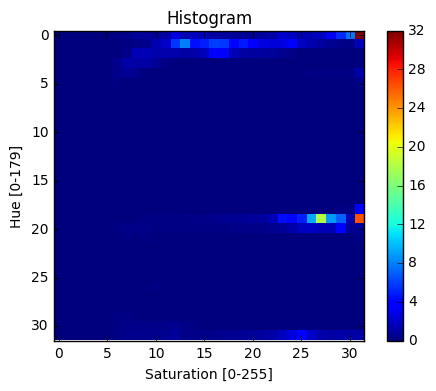

In [272]:
roiHist = hsvHistogram(32)
# roiHist.calcHist([hsv[1]], masks[1])
roiHist.calcHistMask(hsv, masks)
roiHist.normalize()
roiHist.plot()

# Test

Can we find the target image in another picture? The results aren't perfect, but we definately find our target. Now to be fair, these are synthetic images and the artists used the same colors for multiple characters, so I am impressed it worked at all.

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

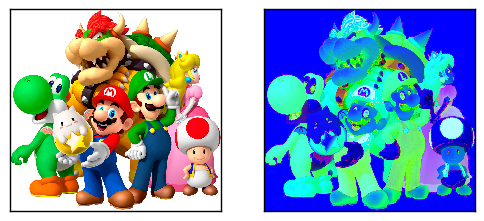

In [290]:
test_rgb = cv2.imread('hist_pics/mario-test2.jpg')
# test_rgb = rgb[0]
test_rgb = cv2.cvtColor(test_rgb, cv2.COLOR_BGR2RGB)  # make pretty for ipython
test_hsv = cv2.cvtColor(test_rgb, cv2.COLOR_RGB2HSV)  # now convert to HSV

plt.subplot(1,2,1)
plt.imshow(test_rgb);
plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(test_hsv);
plt.xticks([]), plt.yticks([])

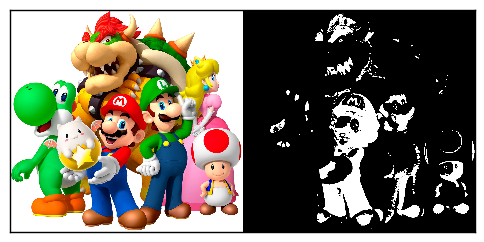

In [291]:
thresh = roiHist.find(test_hsv, 50)
thresh = cv2.merge((thresh,thresh,thresh))  # make 3 channels

# plot ----------
res = cv2.bitwise_and(test_rgb,thresh)
pics = np.hstack((test_rgb,thresh))
plt.imshow(pics);
plt.xticks([]), plt.yticks([]);

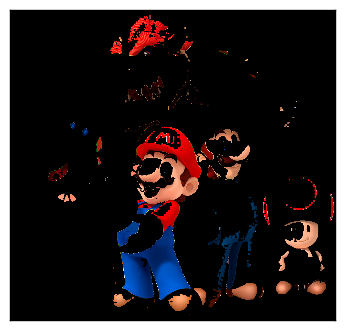

In [292]:
plt.imshow(res);
plt.xticks([]), plt.yticks([]);

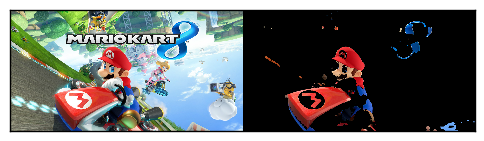

In [293]:
test_rgb = cv2.imread('hist_pics/mario-test4.jpg')
test_rgb = cv2.cvtColor(test_rgb, cv2.COLOR_BGR2RGB)  # make pretty for ipython
test_hsv = cv2.cvtColor(test_rgb, cv2.COLOR_RGB2HSV)  # now convert to HSV
thresh = roiHist.find(test_hsv, 15)
thresh = cv2.merge((thresh,thresh,thresh))  # make 3 channels
res = cv2.bitwise_and(test_rgb,thresh)
pics = np.hstack((test_rgb,res))
plt.imshow(pics);
plt.xticks([]), plt.yticks([]);

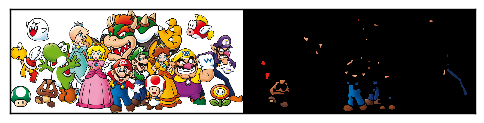

In [294]:
test_rgb = cv2.imread('hist_pics/mario-test.png')
test_rgb = cv2.cvtColor(test_rgb, cv2.COLOR_BGR2RGB)  # make pretty for ipython
test_hsv = cv2.cvtColor(test_rgb, cv2.COLOR_RGB2HSV)  # now convert to HSV
thresh = roiHist.find(test_hsv, 50)
thresh = cv2.merge((thresh,thresh,thresh))  # make 3 channels
res = cv2.bitwise_and(test_rgb,thresh)
pics = np.hstack((test_rgb,res))
plt.imshow(pics);
plt.xticks([]), plt.yticks([]);

In [215]:
# h,s,v = cv2.split(test_hsv)
# plt.subplot(1,2,1)
# plt.grid(True)
# plt.hist(h.ravel(), 32,[0,180], label='hue');
# plt.subplot(1,2,2)
# plt.hist(s.ravel(), 32,[0,255], label='saturation');
# plt.hist(v.ravel(), 32,[0,255], label='value');
# plt.grid(True)
# plt.legend(loc='upper right');

## Tracking

blah ...

blah

So, what is color quantization?

Color quantization is the process of reducing the number of distinct colors in an image.

Normally, the intent is to preserve the color appearance of the image as much as possible, while reducing the number of colors, whether for memory limitations or compression. [ref](http://www.pyimagesearch.com/2014/07/07/color-quantization-opencv-using-k-means-clustering/)

In [ ]:
# print('h x w x channels: {} {} {}'.format(*test.shape))
# print('h x w x channels: {} {} {}'.format(*thresh.shape))

# Conclusions

- Histograms are simple to make and use
- They are widely used because of this simplicity
- However, they are not robust. They fail to take into account:
    - Spacial information
    - Size
    - Shape
    - Texture
- They are susceptable to noise
- They are effected by lighting, but some complensation can be make by using a colorspace like HSV or Lab

# References

---

- [rgb hsv converter](http://colorizer.org/)
- [hsv range](http://docs.opencv.org/3.2.0/df/d9d/tutorial_py_colorspaces.html)

In [3]:
%reload_ext version_information
%version_information numpy, matplotlib, cv2

Software versions
Python 2.7.12 64bit [GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.38)]
IPython 5.1.0
OS Darwin 16.3.0 x86_64 i386 64bit
numpy 1.11.2
matplotlib 1.5.3
cv2 3.1.0-dev
Fri Dec 23 13:47:34 2016 MST


-----------

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.